In [27]:
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot
from shapely.geometry import Point
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
%run -i ../notebooks/functions/functions.py
%run -i ../notebooks/functions/ML_functions.py

## Data Import

In [2]:
master_df = pd.read_csv('../processed_data/master.csv')

In [3]:
X = master_df.iloc[:, 2:]
lat_lng = master_df.iloc[:, 0:2]

X.drop(['DAY CARE', 'wellbeing/hotels', 'density/p_meter', 'NON-PUBLIC K-12 SCHOOLS', 'acres', 'rest_insp_score'], axis=1, inplace=True)

/home/brian/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
#Scaling the data
scaler = StandardScaler()
#fit scaler to data
scaler.fit(X.values)

#transform and save into new dataframe
X_std = pd.DataFrame(scaler.transform(X.values), 
                                columns = X.columns)
    
X_std.head()

,Population,traffic,buildings,legalstories,rating,price,wellbeing/libraries,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS
0,0.440912,-0.648090,-0.441038,-0.956712,-0.289246,0.780088,1.266871,-0.904477,-0.797435
1,-0.884045,-0.563233,-0.458273,-0.340367,-1.232947,0.416751,1.266871,-1.082632,-1.009000
2,-1.131434,0.043021,-0.542293,-0.395411,-1.182391,0.537863,1.266871,-0.191859,-0.797435
3,-0.630074,3.516461,-0.574608,3.690858,-1.401464,1.022312,4.106409,-0.548168,-1.220564
4,0.531145,-0.563233,0.172957,-0.050830,-0.777948,0.416751,-0.152898,-0.191859,1.529774


In [5]:
df_latlong = pd.read_csv('../processed_data/NTA_coords.csv')
df_latlong = df_latlong * 18

X_std = pd.concat([X_std, df_latlong], axis=1)

## Initial Plot of non-binned data

In [6]:
#pop_df = pd.read_csv('../processed_data/density/geocoded_population.csv')
#traf_df = pd.read_csv('../processed_data/density/geocoded_traffic.csv')
#ped_df = pd.read_csv('../processed_data/density/geocoded_pedestrian.csv')
#fac_df = pd.read_csv('../processed_data/buildings/facilities.csv')
#hot_df = pd.read_csv('../processed_data/buildings/hotels.csv')
#lib_df = pd.read_csv('../processed_data/buildings/libraries.csv')
#park_df = pd.read_csv('../processed_data/buildings/parks.csv')
#
#
#crs = {'init': 'epsg:2263'}

In [7]:
#df_list = [pop_df, traf_df, ped_df, fac_df, hot_df, lib_df, park_df]
#new_df_list = llz_set(df_list)

In [8]:
#boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))
#boroughs.plot(ax=ax,alpha=0.4,color="grey")
#
#fig,ax=plt.subplots(figsize=(20,20))
#new_df_list[0].plot(ax = ax, markersize = 15, color = 'blue', marker = 'o', label = 'population')
#new_df_list[1].plot(ax = ax, markersize = 5, color = 'red', marker = 'o', label = 'traffic')
#new_df_list[2].plot(ax = ax, markersize = 5, color = 'green', marker = 'o', label = 'ped_traffic')
#new_df_list[3].plot(ax = ax, markersize = 5, color = 'orange', marker = 'o', label = 'facilities')
#new_df_list[4].plot(ax = ax, markersize = 5, color = 'purple', marker = 'o', label = 'hotels')
#new_df_list[5].plot(ax = ax, markersize = 5, color = 'yellow', marker = 'o', label = 'libraries')
#new_df_list[6].plot(ax = ax, markersize = 5, color = 'pink', marker = 'o', label = 'parks')
#
#plt.legend()
#plt.savefig('../Mid-Term-Project/figures/pre_bin_map.png')

## Elbow Plot

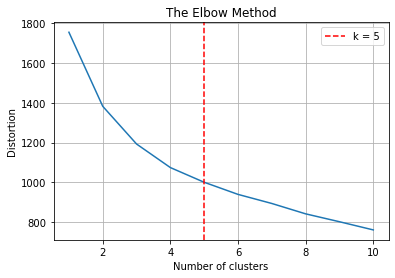

In [25]:
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X_std) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=100)
        model.fit(X_std)
        distortions.append(model.inertia_)

k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

## PCA

In [33]:
pca = PCA()
principalComponents = pca.fit_transform(X_std)
PCA_components = pd.DataFrame(principalComponents)
pca.explained_variance_ratio_

array([0.3112754 , 0.1534554 , 0.11993709, 0.09960652, 0.09595857,
       0.07086947, 0.06300875, 0.04672555, 0.03916324])

In [11]:
km = KMeans(n_clusters=5, n_init=1000)
y_km = km.fit_predict(principalComponents)

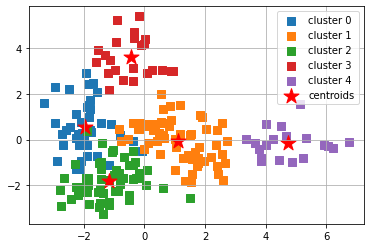

<Figure size 432x288 with 0 Axes>

In [12]:
plot_clusters(principalComponents, y_km, plt_cluster_centers=True)

In [13]:
def plot_dendrogram(X,method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

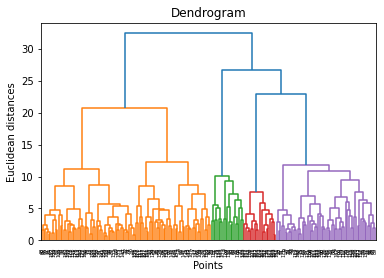

<Figure size 432x288 with 0 Axes>

In [14]:
plot_dendrogram(PCA_components)

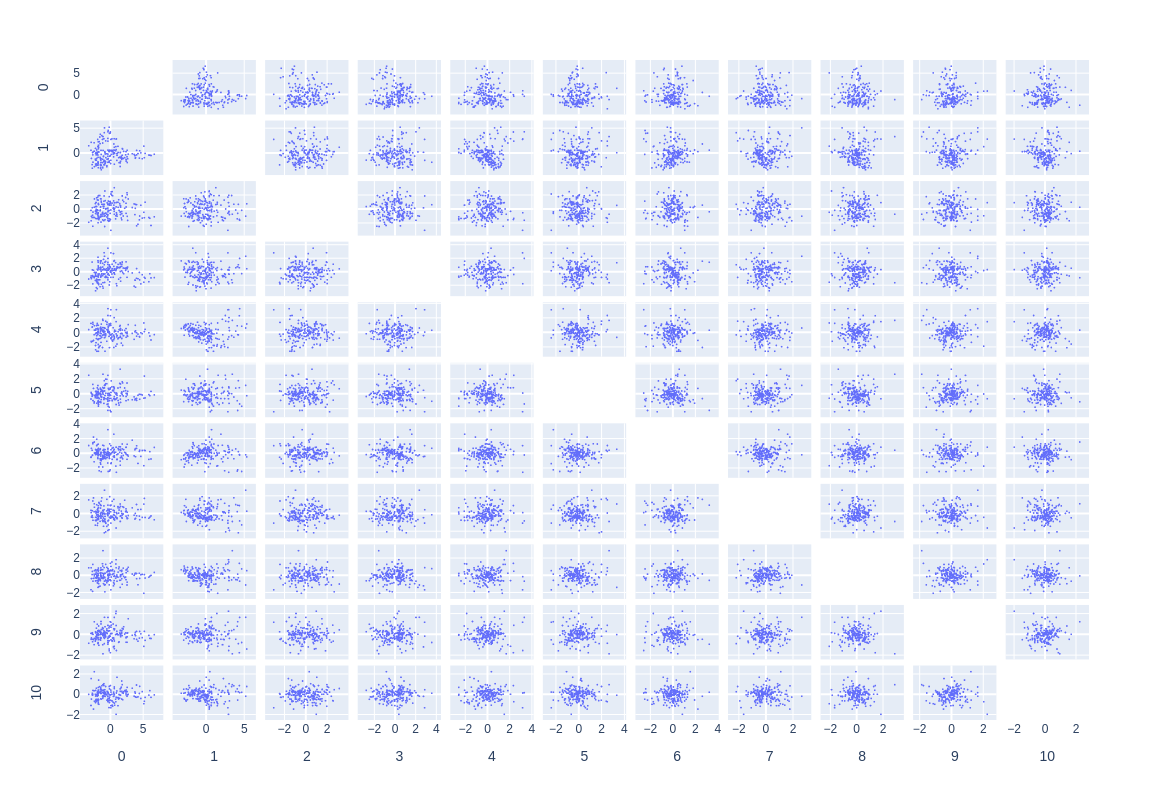

In [32]:
fig = px.scatter_matrix(
    PCA_components,
    width=800, 
    height=800)

fig.update_traces(diagonal_visible=False)
fig.update_traces(marker={'size': 2})
fig.show()

## Multi-Cluster Plots

In [15]:
df_latlong = pd.read_csv('../processed_data/NTA_coords.csv')
df_latlong = df_latlong * 18

X_std_1 = pd.concat([X_std, df_latlong], axis=1)
#X_std = df_latlong

/home/brian/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/brian/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/brian/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindfu

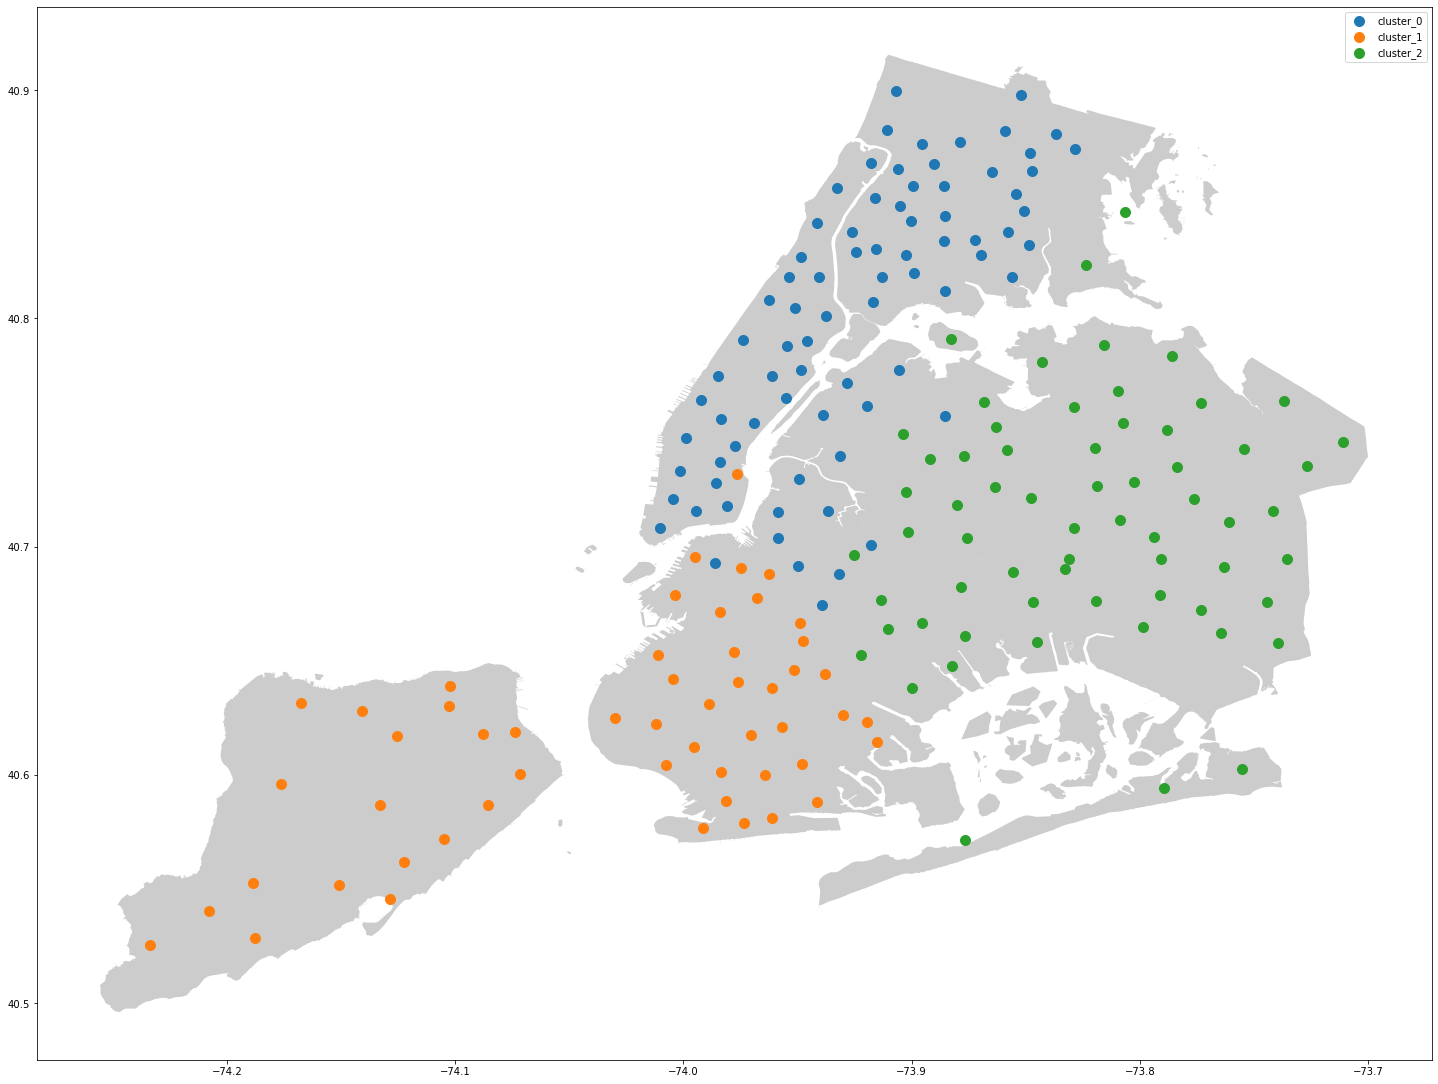

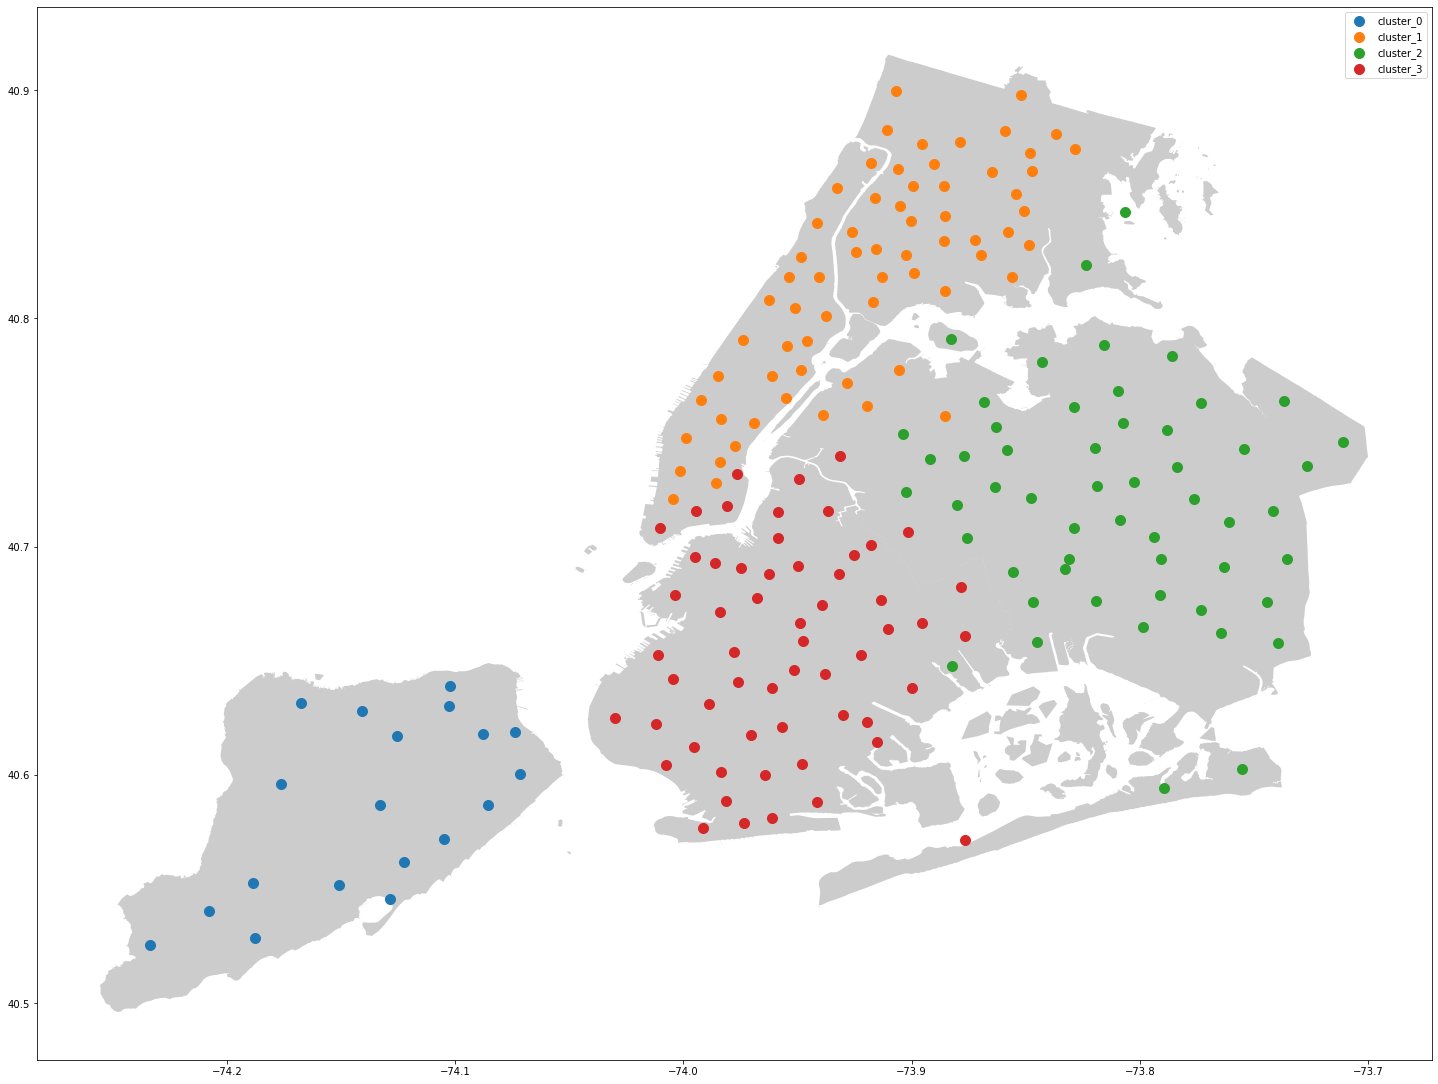

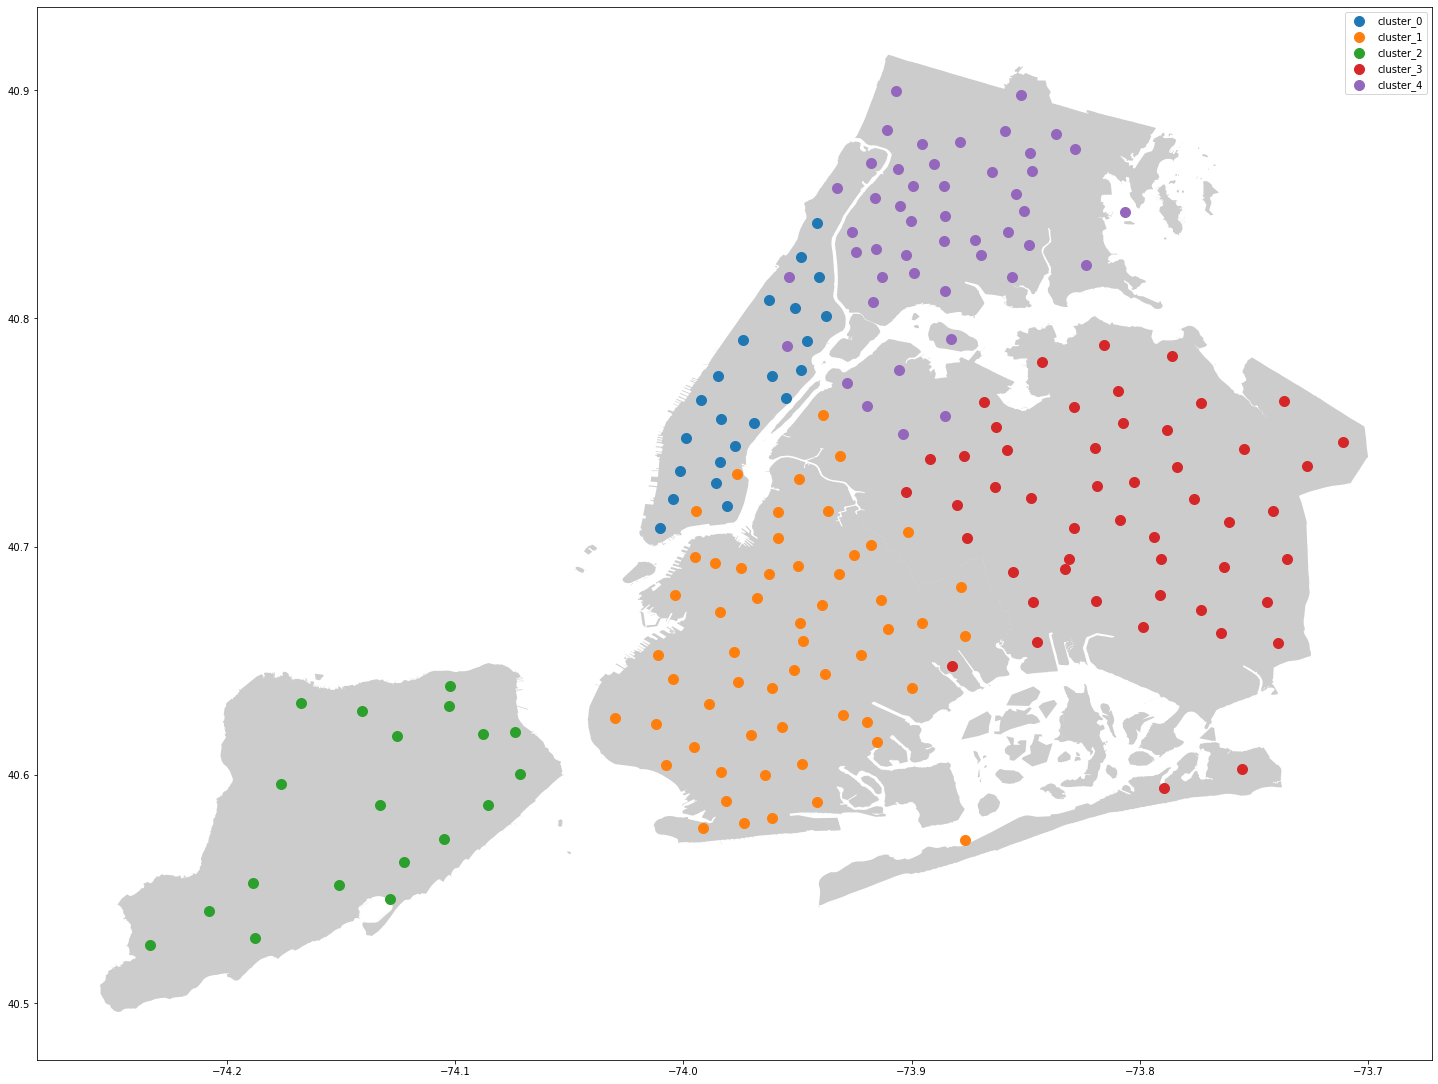

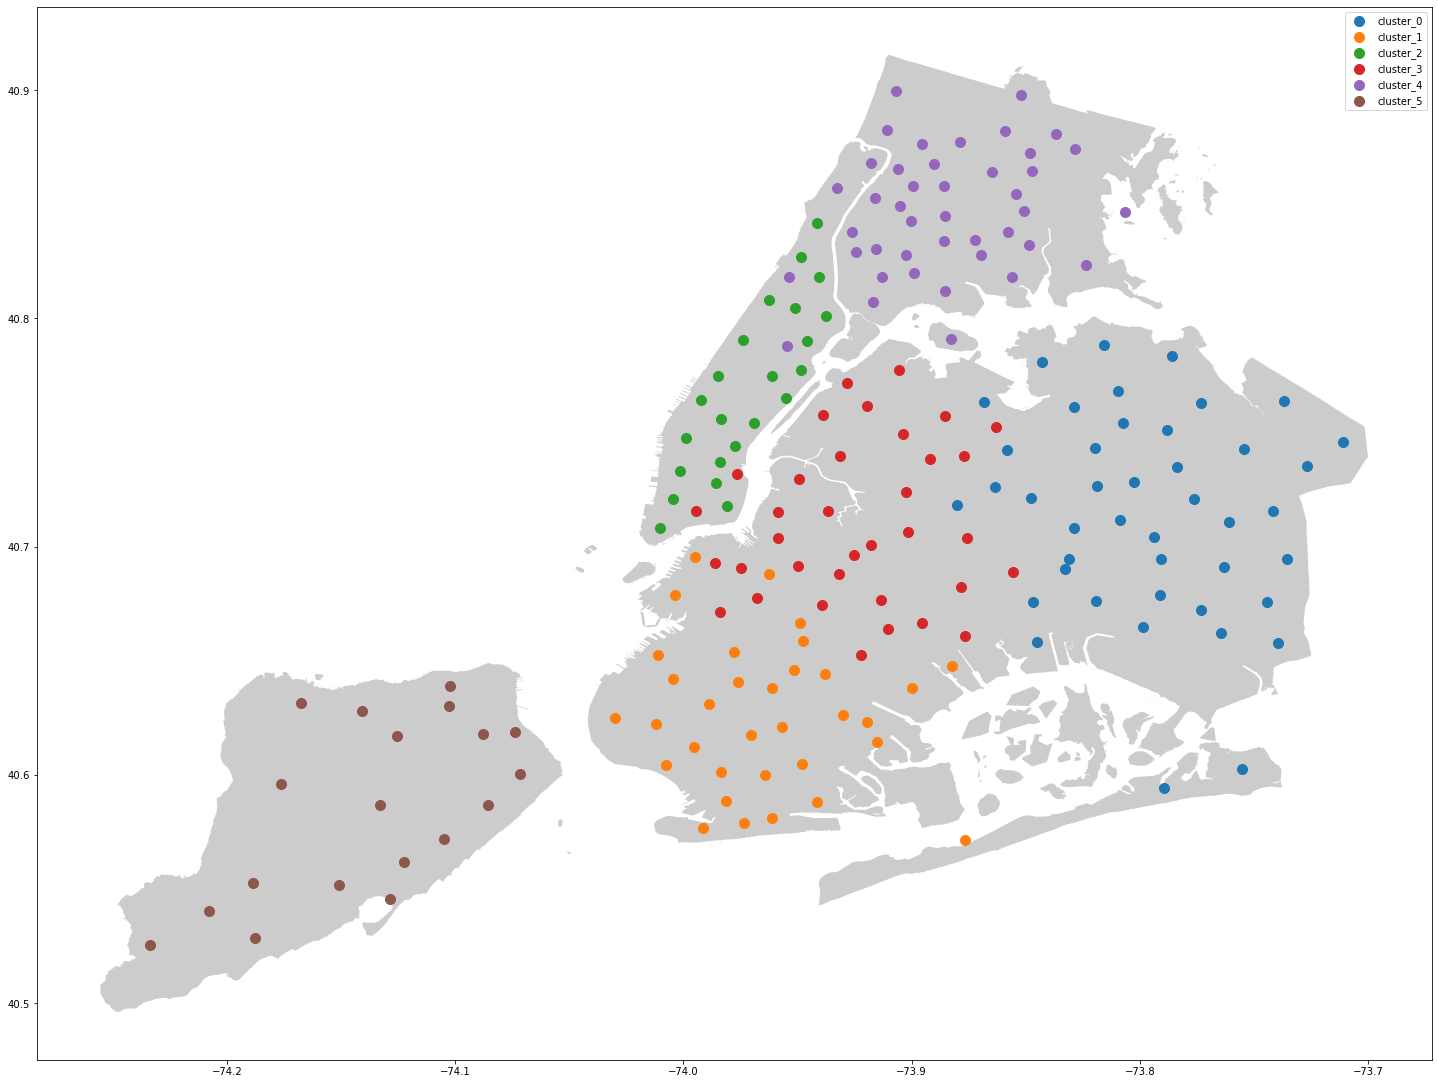

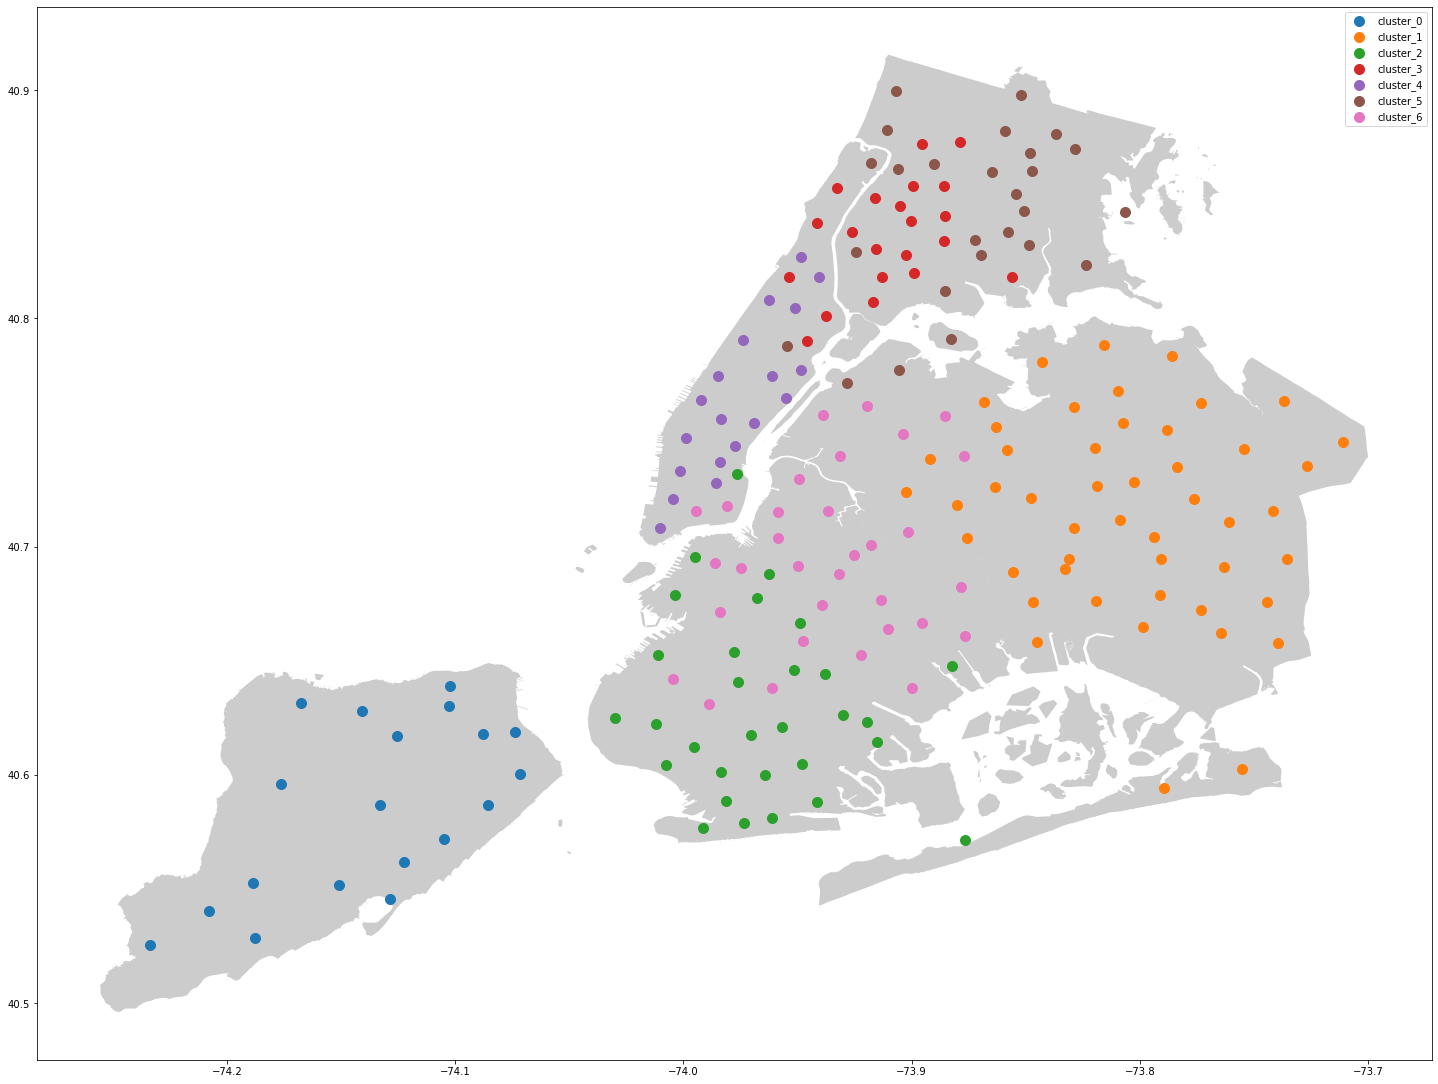

In [16]:
ran = range(3,8)
for i in ran:
    
    X_std_1 = pd.concat([X_std, df_latlong], axis=1)

    k = i
    model = KMeans(n_clusters=k, init='k-means++', random_state=1, max_iter=100)
    ## clustering
    clusters = model.fit_predict(X_std_1)
    
    X_std_1.drop(['NTA_lat', 'NTA_long'], axis=1, inplace=True)

    #Create dataframe with scaled data and cluster info
    cluster_df = pd.concat([X_std_1, pd.DataFrame(clusters)], axis=1)
    cluster_df = cluster_df.rename(columns = {0: 'clusters'})

    df_list = []
    X_plt = pd.concat([lat_lng, cluster_df], axis=1)
    #for each cluster seperate from master dataframe and append to list
    for i in range(0, k):
        df_list.append(X_plt.loc[X_plt['clusters'] == i])

    #zip each clustered dataframe in the list
    cluster_dfs = llz_set(df_list)

    fig,ax=plt.subplots(figsize=(25,25))
    boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))
    boroughs.plot(ax=ax,alpha=0.4,color="grey")

    #loop through each cluster
    for i in range(len(cluster_dfs)):
        cluster_dfs[i].plot(ax = ax, markersize = 100, marker = 'o', label = f"cluster_{i}")
    plt.legend()
#    plt.savefig(f'../figures/appendix/kmeans_map_{i}.png')

In [18]:
#radar_plot(X_std, cluster)   #  , save=f'../figures/appendix/kmeans_radar_{i}.png'

## NTA Area

In [19]:
df_latlong = pd.read_csv('../processed_data/NTA_coords.csv')
df_latlong = df_latlong * 18

X_std = pd.concat([X_std, df_latlong], axis=1)
#X_std = df_latlong

In [20]:
k = 5
model = KMeans(n_clusters=k, init='k-means++', random_state=1, max_iter=100)
## clustering
clusters = model.fit_predict(X_std)

X_std.drop(['NTA_lat', 'NTA_long'], axis=1, inplace=True)

#Create dataframe with scaled data and cluster info
cluster_df = pd.concat([X_std, pd.DataFrame(clusters)], axis=1)
cluster_df = cluster_df.rename(columns = {0: 'clusters'})

In [21]:
df_list = []
X_plt = pd.concat([lat_lng, cluster_df], axis=1)
#for each cluster seperate from master dataframe and append to list
for i in range(0, k):
    df_list.append(X_plt.loc[X_plt['clusters'] == i])

#zip each clustered dataframe in the list
cluster_dfs = llz_set(df_list)

/home/brian/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


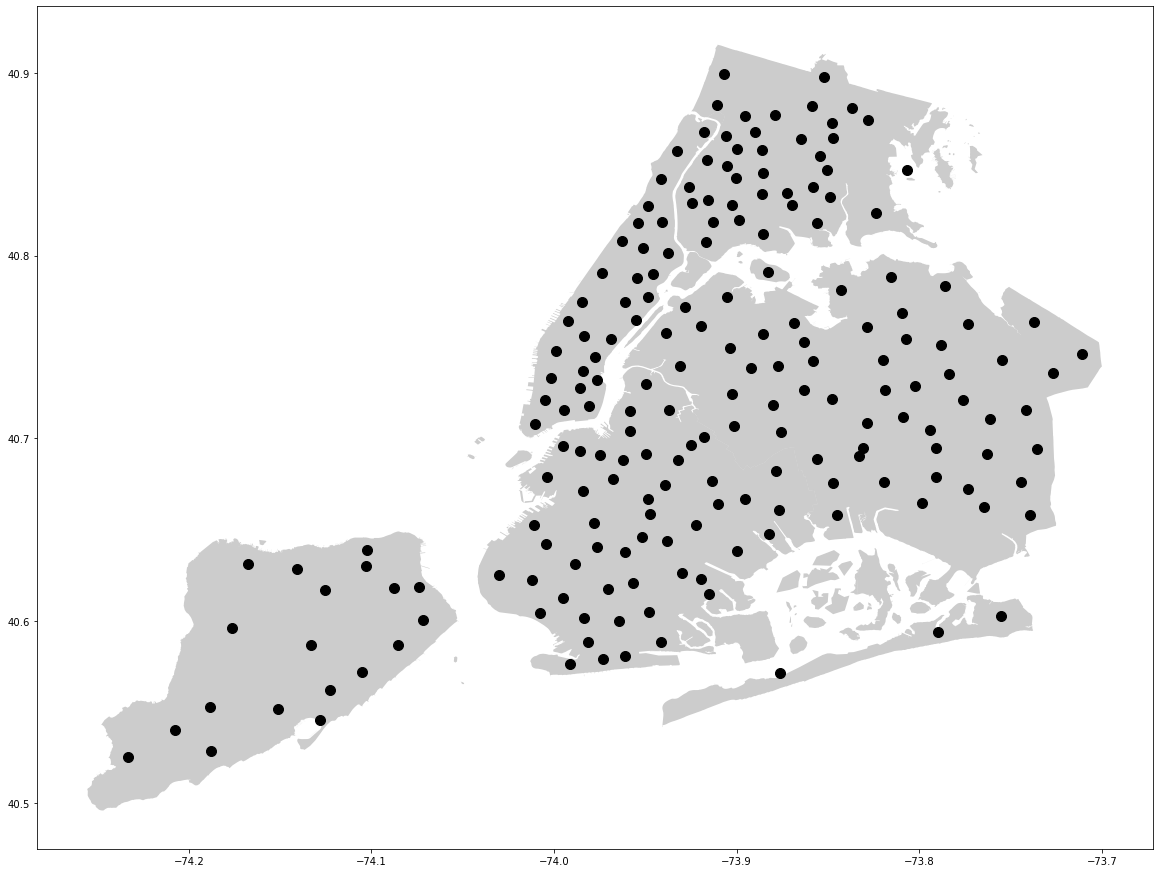

In [22]:
fig,ax=plt.subplots(figsize=(20,20))
boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))
boroughs.plot(ax=ax,alpha=0.4,color="grey")

#loop through each cluster
for i in range(len(cluster_dfs)):
    cluster_dfs[i].plot(ax = ax, markersize = 100, color='black', marker = 'o', label = f"cluster_{i}")
#plt.legend()
plt.savefig('../figures/appendix/NTAs.png')